This is an adaptation of Craig Reynold's Boids model for collective
behaviour. Agents follow 3 rules: attraction (cohesion), repulsion
(separation), and alignment, which lead to an organized flock or school.

The model is built using the Mesa framework for agent-based modeling 
in Python.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mesa import Agent
%matplotlib inline


class Boid(Agent):
    """ A Boid-style flocker agent. Boids have a vision that defines the radius in
    which they look for their neighbors to flock with. Their speed (a scalar) and
    heading (a unit vector) define their movement. Separation is their desired 
    minimum distance from any other Boid. """
    def __init__(self, unique_id, model, pos, speed=5, heading=None,
                 vision=5, separation=1):
        """ Create a new Boid flocker agent. Args:
            unique_id: Unique agent identifyer.
            pos: Starting position
            speed: Distance to move per step.
            heading: numpy vector for the Boid's direction of movement.
            vision: Radius to look around for nearby Boids.
            separation: Minimum distance to maintain from other Boids. """
        super().__init__(unique_id, model)
        self.pos = pos
        self.speed = speed
        if heading is not None:
            self.heading = heading
        else:
            self.heading = np.random.random(2)
            self.heading /= np.linalg.norm(self.heading)
        self.vision = vision
        self.separation = separation

    def cohere(self, neighbors):
        """ Return the vector toward the center of mass of the local neighbors. """
        center = np.array([0.0, 0.0])
        for neighbor in neighbors:
            center += np.array(neighbor.pos)
        return center / len(neighbors)

    def separate(self, neighbors):
        """ Return a vector away from any neighbors closer than separation dist. """
        my_pos = np.array(self.pos)
        sep_vector = np.array([0, 0])
        for neighbor in neighbors:
            their_pos = np.array(neighbor.pos)
            dist = np.linalg.norm(my_pos - their_pos)
            if dist < self.separation:
                sep_vector -= np.int64(their_pos - my_pos)
        return sep_vector

    def match_heading(self, neighbors):
        """ Return a vector of the neighbors' average heading. """
        mean_heading = np.array([0, 0])
        for neighbor in neighbors:
            mean_heading += np.int64(neighbor.heading)
        return mean_heading / len(neighbors)

    def step(self):
        """ Get the Boid's neighbors, compute the new vector, and move accordingly."""
        neighbors = self.model.space.get_neighbors(self.pos, self.vision, False)
        if len(neighbors) > 0:
            cohere_vector = self.cohere(neighbors)
            separate_vector = self.separate(neighbors)
            match_heading_vector = self.match_heading(neighbors)
            self.heading += (cohere_vector +
                             separate_vector +
                             match_heading_vector)
            self.heading /= np.linalg.norm(self.heading)
        new_pos = np.array(self.pos) + self.heading * self.speed
        new_x, new_y = new_pos
        self.model.space.move_agent(self, (new_x, new_y))

In [9]:
""" Uses numpy arrays to represent vectors. """

import random
from mesa import Model
from mesa.space import ContinuousSpace
from mesa.time import RandomActivation


class BoidModel(Model):
    """ Flocker model class. Handles agent creation, placement and scheduling. """

    def __init__(self, N, width, height, speed, vision, separation):
        """ Create a new Flockers model.
        Args:
            N: Number of Boids
            width, height: Size of the space.
            speed: How fast should the Boids move.
            vision: How far around should each Boid look for its neighbors
            separation: What's the minimum distance each Boid will attempt to
                       keep from any other """
        self.N = N
        self.vision = vision
        self.speed = speed
        self.separation = separation
        self.schedule = RandomActivation(self)
        self.space = ContinuousSpace(width, height, True,
                                     grid_width=10, grid_height=10)
        self.make_agents()
        self.running = True

    def make_agents(self):
        """ Create N agents, with random positions and starting headings. """
        for i in range(self.N):
            x = random.random() * self.space.x_max
            y = random.random() * self.space.y_max
            pos = (x, y)
            heading = np.random.random(2) * 2 - np.array((1, 1))
            heading /= np.linalg.norm(heading)
            boid = Boid(i, self, pos, self.speed, heading, self.vision,
                        self.separation)
            self.space.place_agent(boid, pos)
            self.schedule.add(boid)

    def step(self):
        self.schedule.step()

In [4]:
def draw_boids(model):
    x_vals = []
    y_vals = []
    for boid in model.schedule.agents:
        x, y = boid.pos
        x_vals.append(x)
        y_vals.append(y)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.scatter(x_vals, y_vals)

In [10]:
model = BoidModel(100, 100, 100, speed=5, vision=5, separation=1)

In [11]:
for i in range(50):
    model.step()

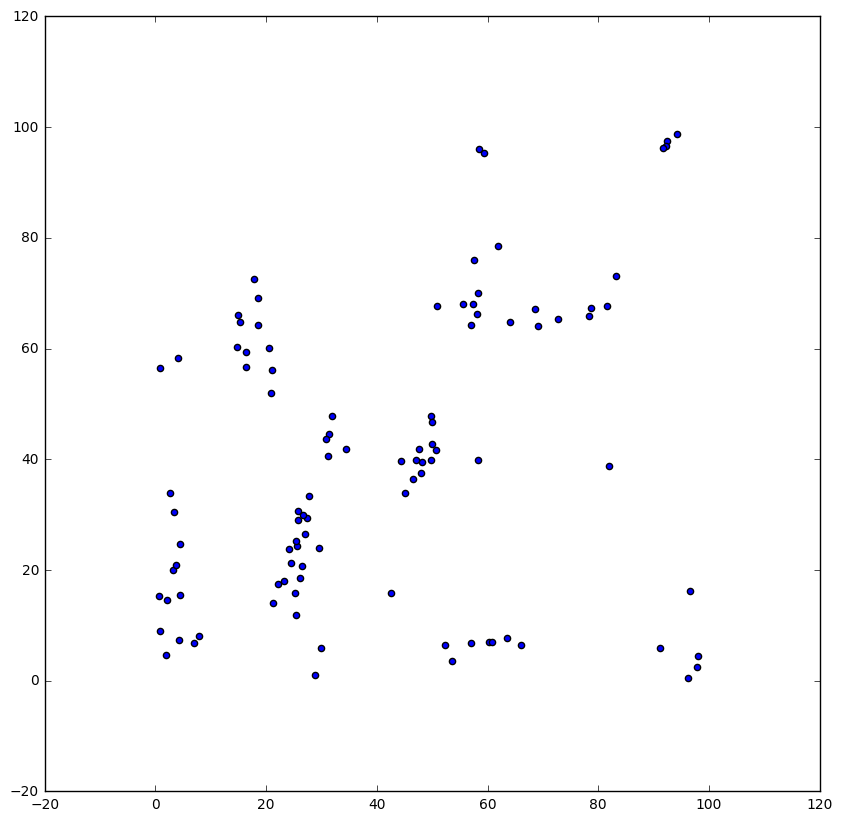

In [12]:
draw_boids(model)